<a href="https://colab.research.google.com/github/ShubhMody/Brain-Tumor-Detection-from-MRI-Scans/blob/main/AI_Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Data source: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Navigate to My Drive directory to store the dataset
%cd /content/drive/My Drive/Portfolio Projects - Machine Learning/Healthcare AI/Brain_MRI


/content/drive/My Drive/Portfolio Projects - Machine Learning/Healthcare AI/Brain_MRI


In [4]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

In [5]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [6]:
brain_df.head(50)

patient_id                                         image_path  \
0   TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1   TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2   TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3   TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4   TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
5   TCGA_CS_5395_19981004  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif   
6   TCGA_CS_5395_19981004  TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif   
7   TCGA_CS_5395_19981004  TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif   
8   TCGA_CS_5395_19981004  TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif   
9   TCGA_CS_5395_19981004  TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif   
10  TCGA_CS_5395_19981004  TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1.tif   
11  TCGA_CS_5395_19981004  TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_1.tif   
12  TCGA_CS_5395_19981004  TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_1.tif   
13  TCGA_CS_5395_19981004  TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_1.tif   
14  TCGA_CS_5395_19981004  TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_1.tif   
15  TCGA_CS_5395_19981004  TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_1.tif   
16  TCGA_CS_5395_19981004  TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_1.tif   
17  TCGA_CS_5395_19981004  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_1.tif   
18  TCGA_CS_5395_19981004  TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_1.tif   
19  TCGA_CS_5395_19981004  TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_1.tif   
20  TCGA_CS_4944_20010208  TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1.tif   
21  TCGA_CS_4944_20010208  TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1.tif   
22  TCGA_CS_4944_20010208  TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1.tif   
23  TCGA_CS_4944_20010208  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1.tif   
24  TCGA_CS_4944_20010208  TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1.tif   
25  TCGA_CS_4944_20010208  TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1.tif   
26  TCGA_CS_4944_20010208  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_1.tif   
27  TCGA_CS_4944_20010208  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1.tif   
28  TCGA_CS_4944_20010208  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1.tif   
29  TCGA_CS_4944_20010208  TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1.tif   
30  TCGA_CS_4944_20010208  TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_1.tif   
31  TCGA_CS_4944_20010208  TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_1.tif   
32  TCGA_CS_4944_20010208  TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_1.tif   
33  TCGA_CS_4944_20010208  TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_1.tif   
34  TCGA_CS_4944_20010208  TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_1.tif   
35  TCGA_CS_4944_20010208  TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_1.tif   
36  TCGA_CS_4944_20010208  TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_1.tif   
37  TCGA_CS_4944_20010208  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_1.tif   
38  TCGA_CS_4944_20010208  TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif   
39  TCGA_CS_4944_20010208  TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif   
40  TCGA_CS_4941_19960909  TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_1.tif   
41  TCGA_CS_4941_19960909  TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_1.tif   
42  TCGA_CS_4941_19960909  TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_1.tif   
43  TCGA_CS_4941_19960909  TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif   
44  TCGA_CS_4941_19960909  TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_1.tif   
45  TCGA_CS_4941_19960909  TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_1.tif   
46  TCGA_CS_4941_19960909  TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_1.tif   
47  TCGA_CS_4941_19960909  TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_1.tif   
48  TCGA_CS_4941_19960909  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_1.tif   
49  TCGA_CS_494

In [7]:
brain_df.mask_path[1] # Path to the brain MRI image

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [8]:
brain_df.image_path[1] # Path to the segmentation mask

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

In [9]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [10]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [11]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [12]:
# Using plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,100,0)', marker_line_color = 'rgb(70,255,0)',
                  marker_line_width = 5, opacity = 0.6)
fig.show()

In [13]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [14]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

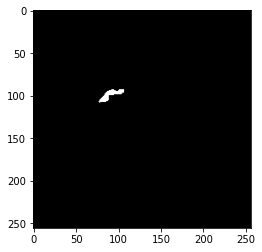

In [15]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

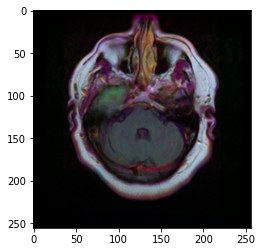

In [16]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [17]:
cv2.imread(brain_df.mask_path[623]).max()

255

In [18]:
cv2.imread(brain_df.mask_path[623]).min()

0

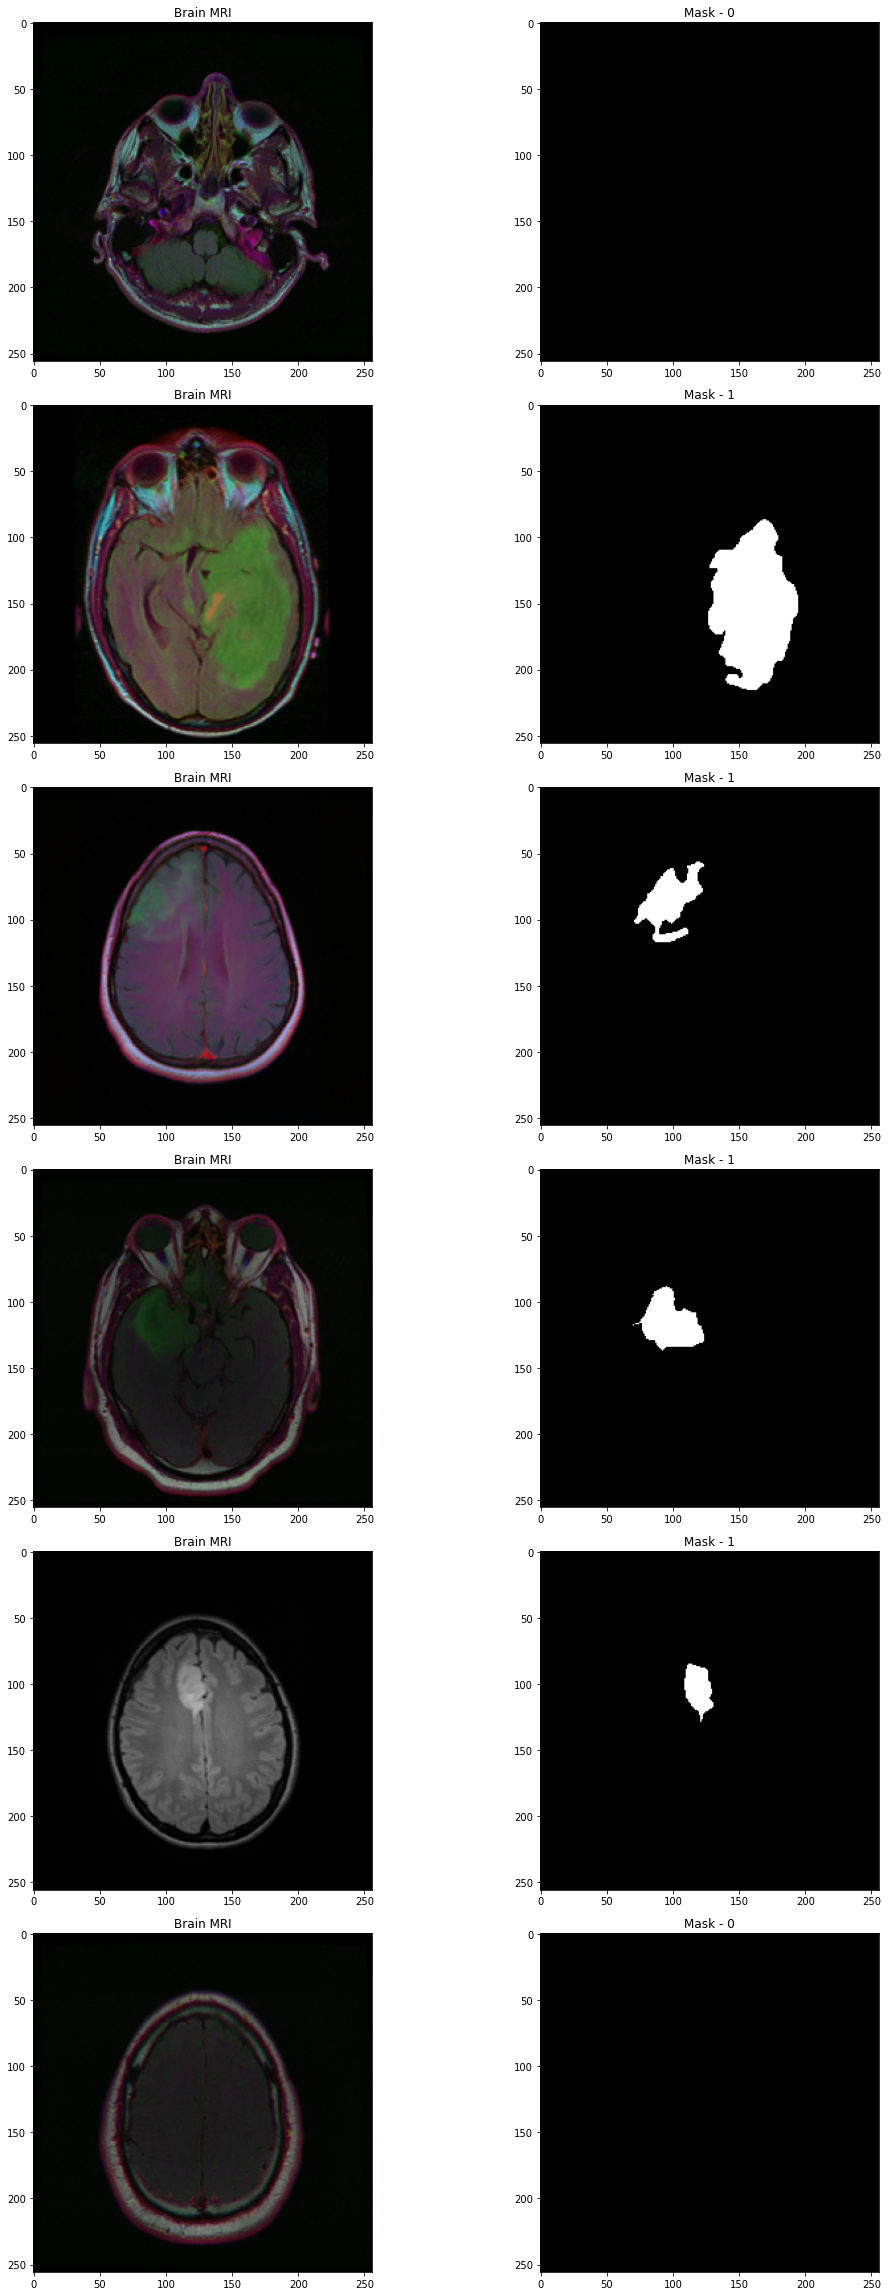

In [19]:
#Visualizing the images (MRI and Mask) in the dataset separately 
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # selecting a random index
  axs[count][0].title.set_text("Brain MRI") 
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # showing MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plotting title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Showing corresponding mask
  count += 1

fig.tight_layout()

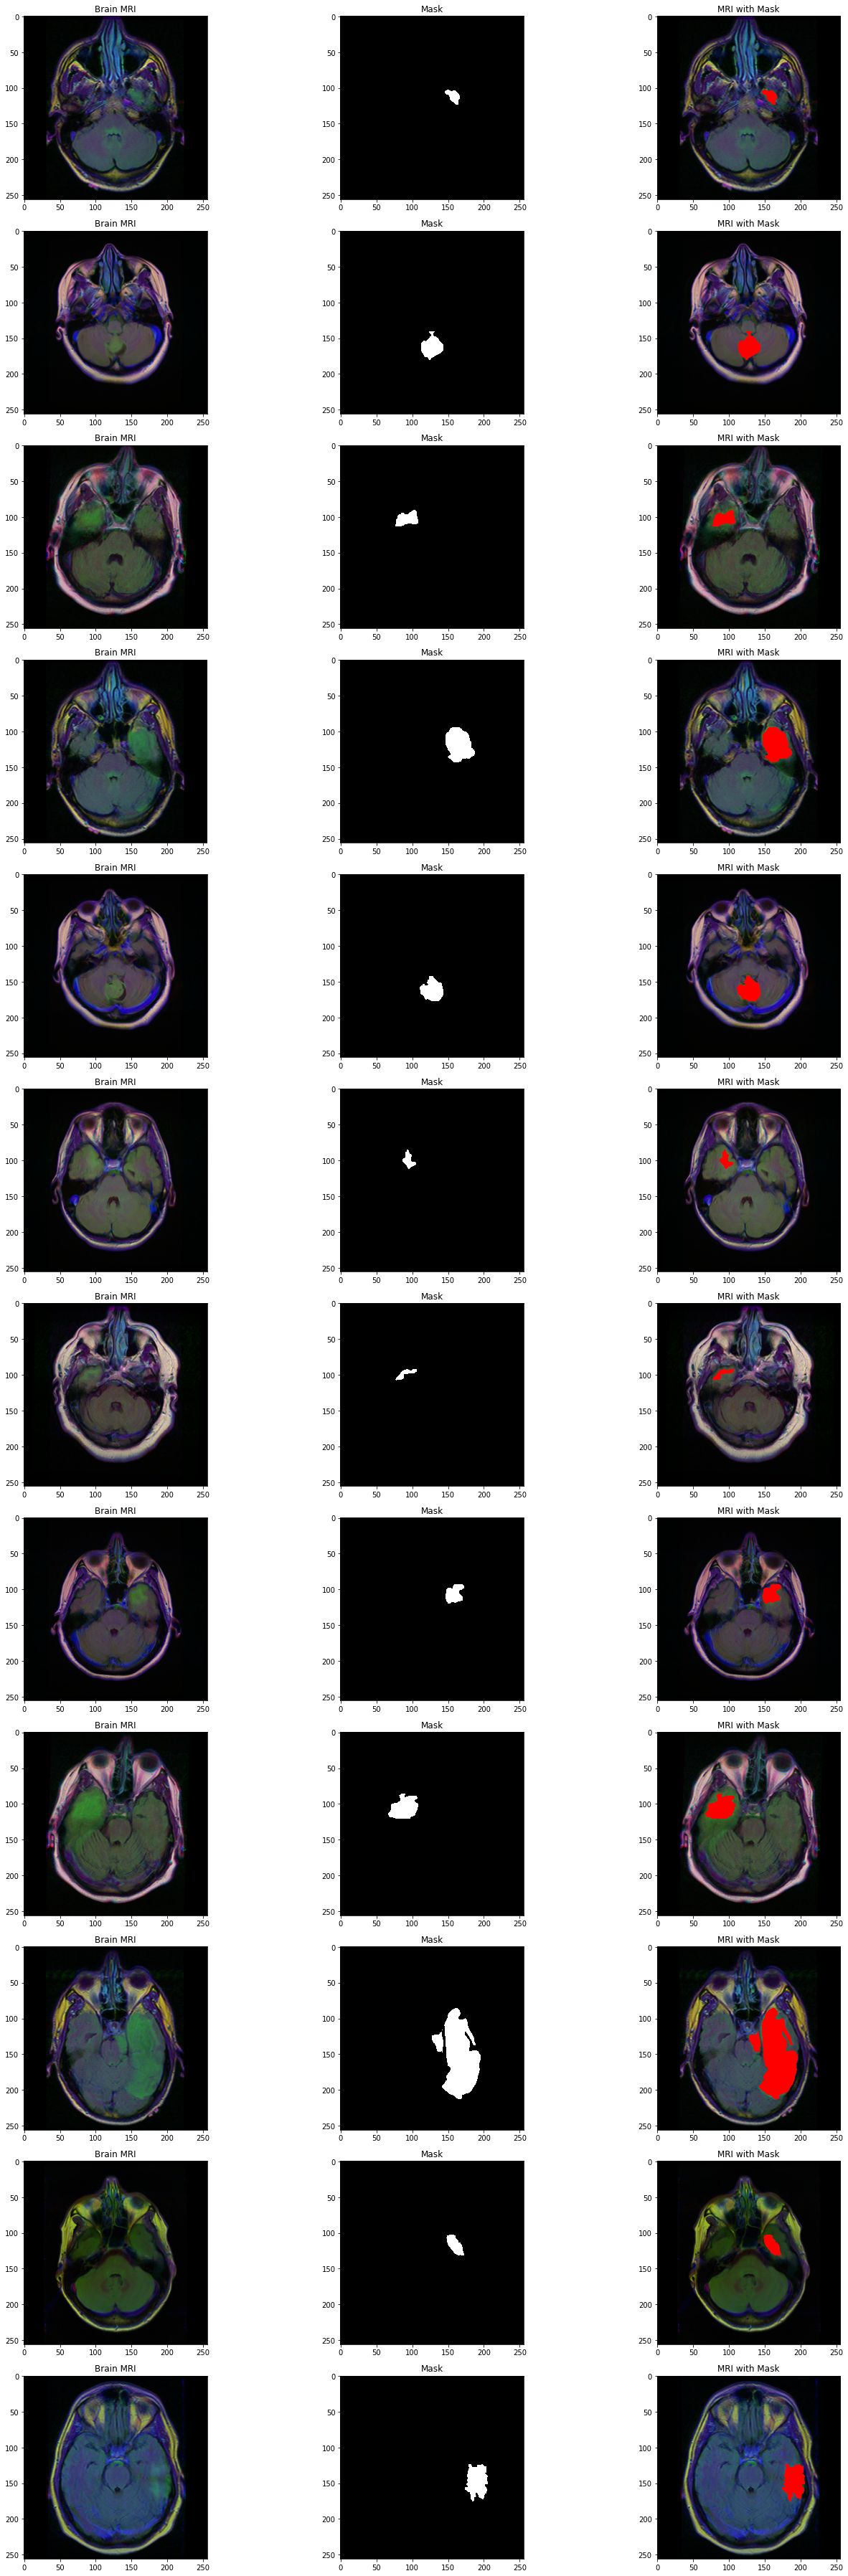

In [20]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


In [21]:
# Dropping the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [22]:
# Converting the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [23]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [24]:
# splitting the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [25]:
# creating an image generator
from keras_preprocessing.image import ImageDataGenerator

# Creating a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [26]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Creating a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [27]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

In [28]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [29]:
# freezing the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [30]:
# Adding classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [32]:
# compiling the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [33]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# saving the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [34]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

177/177 [==============================] - ETA: 0s - loss: 0.9397 - accuracy: 0.6624
Epoch 1: val_loss improved from inf to 0.64324, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 776s 4s/step - loss: 0.9397 - accuracy: 0.6624 - val_loss: 0.6432 - val_accuracy: 0.5504


In [35]:
# saving the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [36]:
# Loading pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# loading the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [37]:
# making prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 127s 4s/step


In [38]:
test_predict.shape

(576, 2)

In [39]:
test_predict

array([[1.0000000e+00, 1.4486883e-12],
       [1.5153576e-07, 9.9999988e-01],
       [9.9534506e-01, 4.6549290e-03],
       ...,
       [9.9705744e-01, 2.9425358e-03],
       [9.9918443e-01, 8.1550085e-04],
       [9.9998379e-01, 1.6216816e-05]], dtype=float32)

In [40]:
# Obtaining the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [41]:
predict

array(['0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '1',
       '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0',
       '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1',
       '1', '0', '1', '0', '0', '0', '0', '1', '0', '1', '1', '0', '1',
       '1', '1', '0', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0',
       '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '1',
       '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0',
       '1', '1', '0', '0', '1', '1', '1', '0', '1', '0', '0', '0', '0',
       '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0',
       '1', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1

In [42]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [43]:
# Obtaining the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9722222222222222

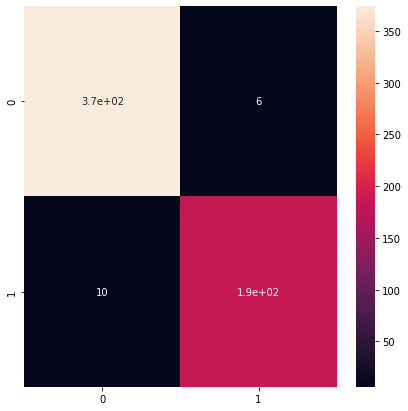

In [44]:
# plotting the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [45]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       380
           1       0.97      0.95      0.96       196

   micro avg       0.97      0.97      0.97       576
   macro avg       0.97      0.97      0.97       576
weighted avg       0.97      0.97      0.97       576



/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [46]:
# Getting the dataframe containing MRIs which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [47]:
# splitting the data into train and test data

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [48]:
# creating separate list for imageId, classId to pass into the generator

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [49]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# creating image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [50]:
def resblock(X, f):
  

  # making a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [51]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [52]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [53]:
model_seg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [54]:
# Utilities file contains the code for custom loss function and custom data generator

from utilities import focal_tversky, tversky_loss, tversky

In [55]:
# Compiling the model
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [56]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# saving the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [57]:
history = model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

72/72 [==============================] - ETA: 0s - loss: 0.8568 - tversky: 0.1857
Epoch 1: val_loss improved from inf to 0.84510, saving model to ResUNet-weights.hdf5
72/72 [==============================] - 339s 5s/step - loss: 0.8568 - tversky: 0.1857 - val_loss: 0.8451 - val_tversky: 0.2008


In [58]:
# saving the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

In [59]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# loading the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [60]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction

# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

In [61]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

image_path  \
0    TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_9.tif   
1    TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_30...   
2    TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_43...   
3    TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_18...   
4    TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_4.tif   
..                                                 ...   
585  TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_19...   
586  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_74...   
587  TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_34...   
588  TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_18...   
589  TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_12...   

                                        predicted_mask  has_mask  
0                                              No mask         0  
1    [[[[2.9249696e-07], [9.2957765e-07], [2.021469...         1  
2                                              No mask         0  
3    [[[[7.869822e-07], [3.2025262e-06], [7.7525065...         1  
4                                              No mask         0  
..                                                 ...       ...  
585  [[[[7.732318e-07], [3.4738296e-06], [1.0240215...         1  
586                                            No mask         0  
587                                            No mask         0  
588  [[[[7.7749394e-07], [3.2862597e-06], [8.607086...         1  
589  [[[[7.0919003e-07], [3.0192853e-06], [8.176687...         1  

[590 rows x 3 columns]

In [62]:
# Merging the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_9.tif   
1  TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_30...   
2  TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_43...   
3  TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_18...   
4  TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_4.tif   

                                           mask_path mask  \
0  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_9_...    0   
1  TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_30...    1   
2  TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_43...    0   
3  TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_18...    1   
4  TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_4_...    0   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1  [[[[2.9249696e-07], [9.2957765e-07], [2.021469...         1  
2                                            No mask         0  
3  [[[[7.869822e-07], [3.2025262e-06], [7.7525065...         1  
4                                            No mask         0

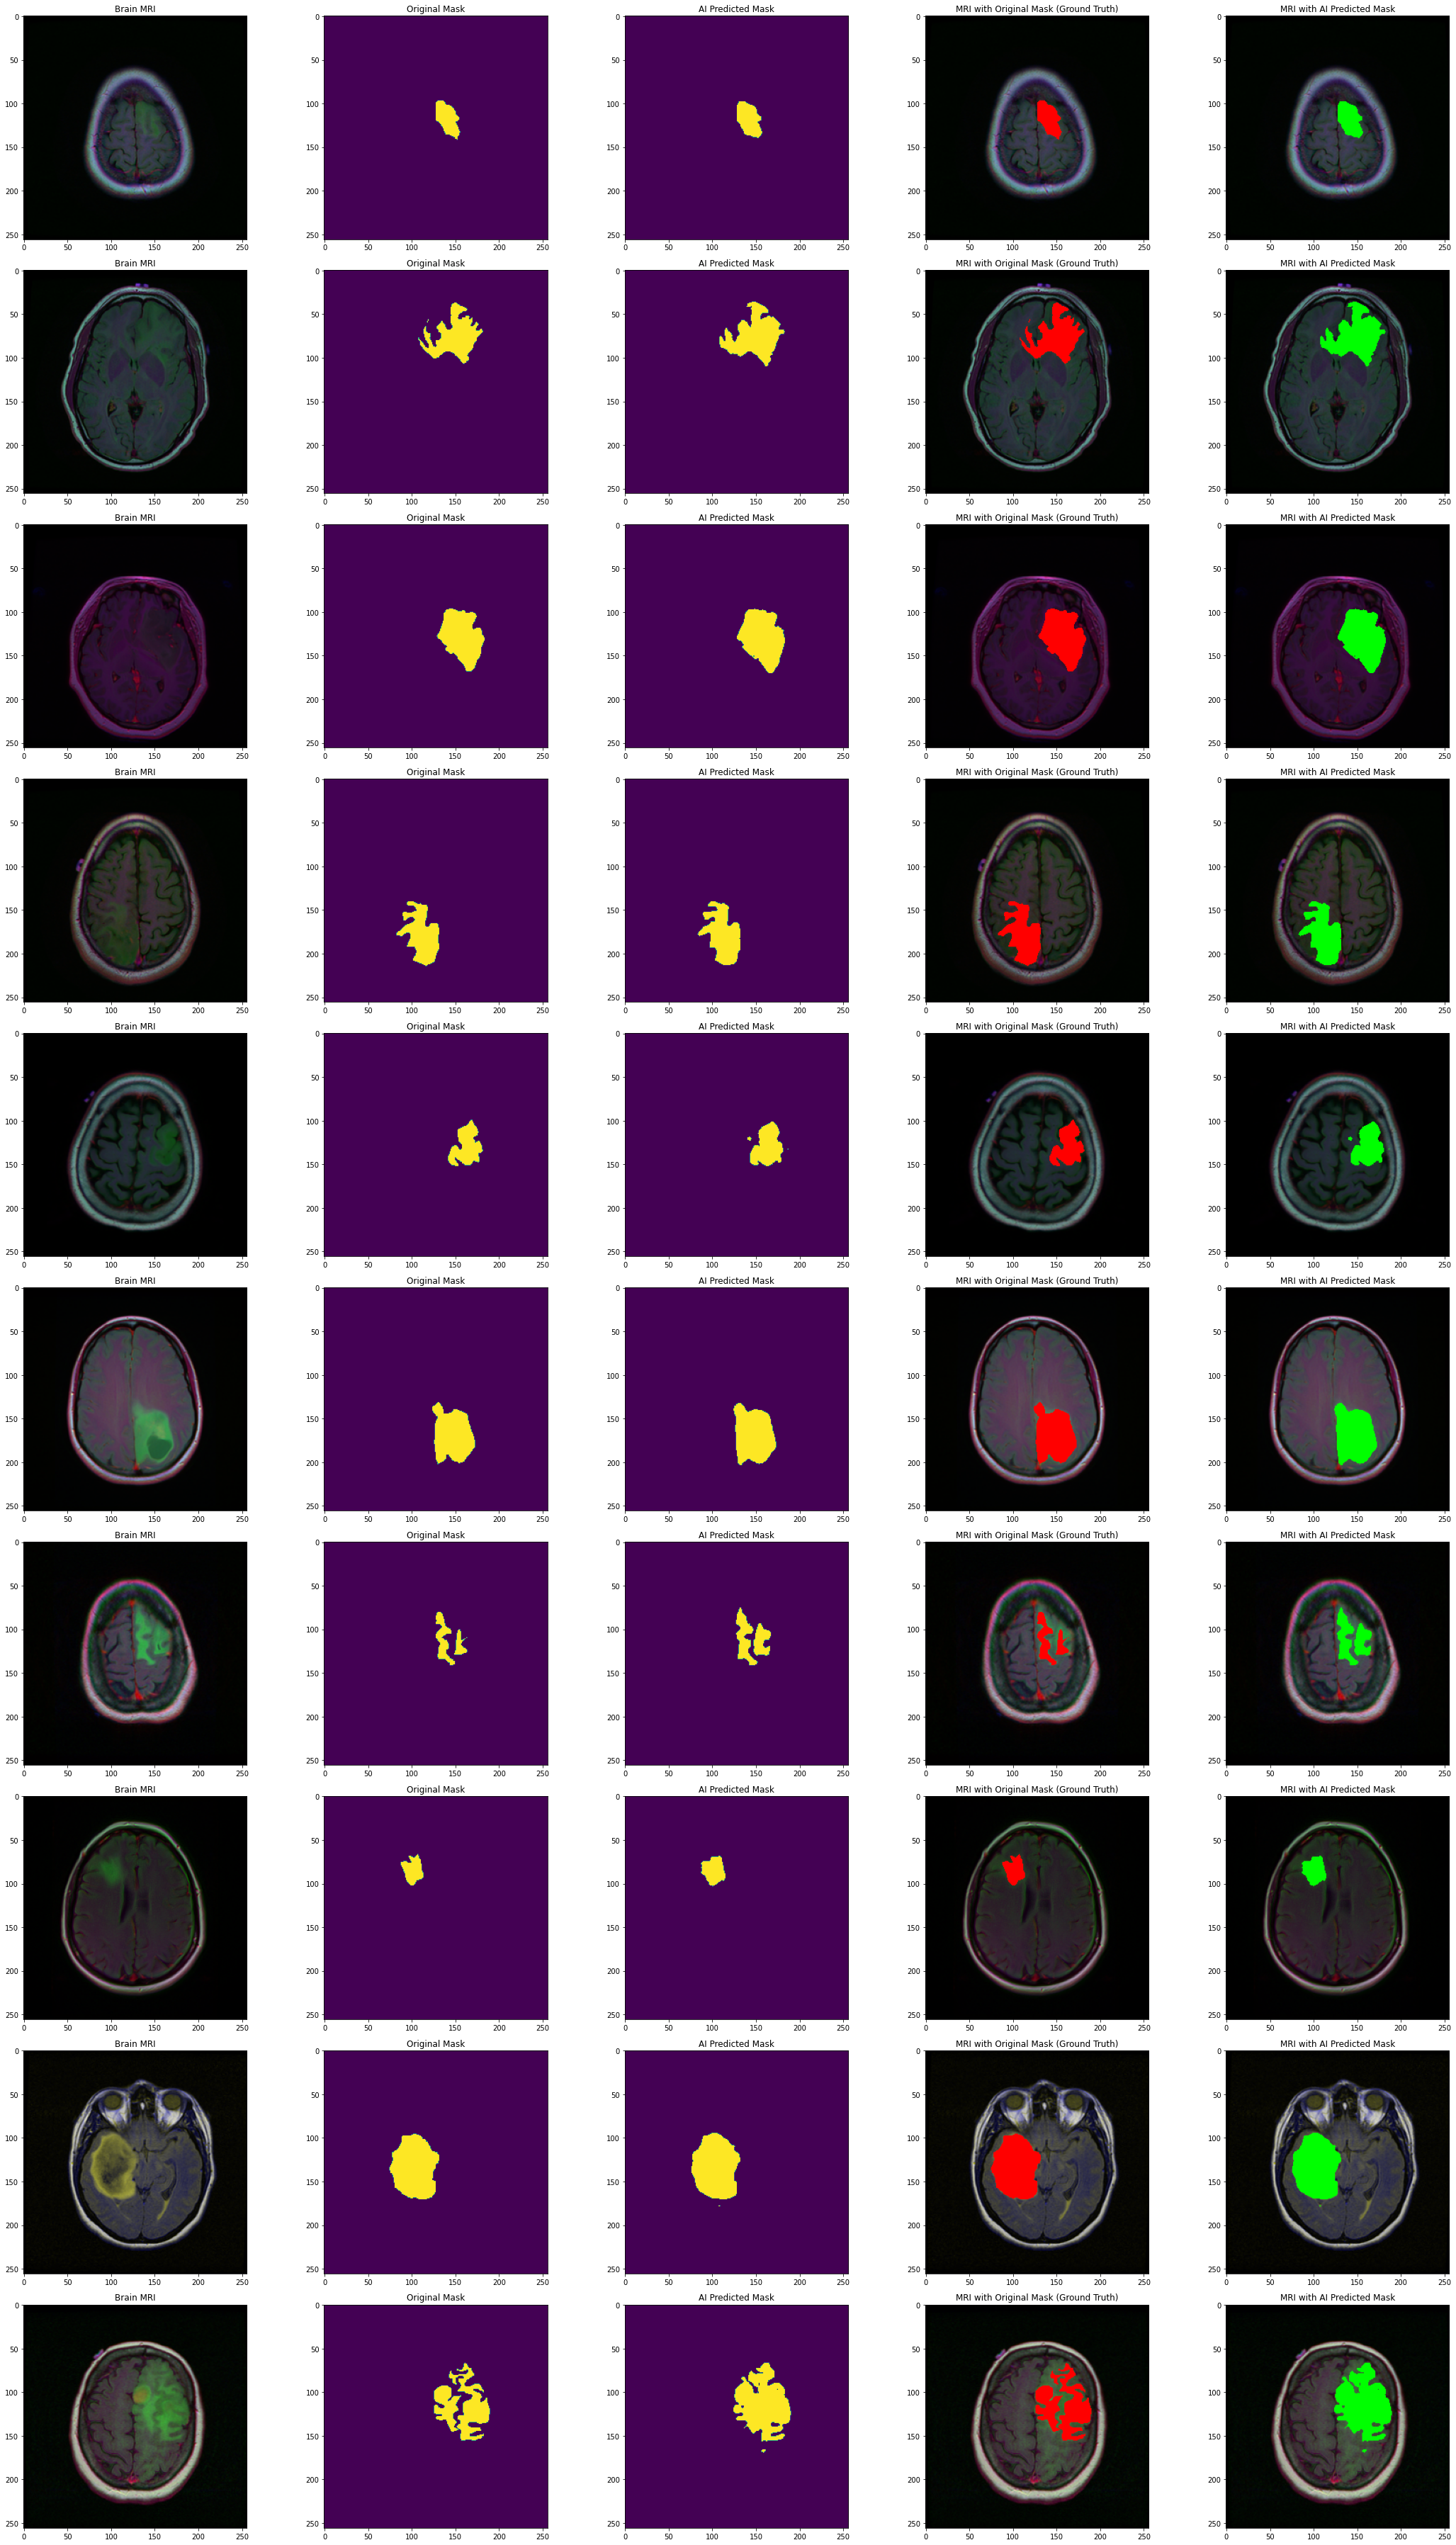

In [63]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # reading the images and converting them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtaining the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtaining the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Applying the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()